## 1. Basic 3D model: Diffusion limited aggregation 

Our model simulates the growth of a coral structure using the principles of diffusion-limited aggregation. 
- Particles are randomly spawned on a sphere around the cluster.
- These particles perform a random walk until they attach to the existing coral.
- Growth is governed by parameters like stickiness (k_cons) and a minimum radius (rmin) defining the growth region.

This model produces fractal structures as seen in real-life corals.

### Computational Approach

1. The model uses a 3D grid of size N × N × N, where N = 2 × rmax + 3
2. The seed to start the coral is placed at the center of the base of the grid (m, m, 0) 
3. Particles are spawned randomly on a sphere so that they're equidistant from the center. The spawning radius is slightly beyond the current growth region (rmin + 2) to provide a buffer for random movement.
4. Particles perform a random walk in 3D space until they stick to the cluster, or escape the growth region (in which case they're discarded)
5. the stickiness probability ('threshold') governs whether a particle attached to the coral. It is defined as: 

   threshold = k_cons × z + 0.2

  - z is the particle's height, in this way we bias the coral towards upward growth (mimicing the biological mechanism of growth towards light)
  - k_cons is a tunable parameter to adjust the likelihood of attachment
6. To determine if a particle is near the coral cluster, its adjacent cells are checked. If any neighbor is part of the cluster, the particle is allowed to stick.
7. The simulation stops when the cluster reaches a predefined maximum radius, or a predefined computational limit is reached 

#### Complexity
- space: the 3D grid requires O(N^3) memory 
- time: the random walk and neighbor check operations are the most computationally heavy 
- the use of Numba JIT compiler speeds up our operations 

#### Spherical coordinates

The spherical coordinates `(r, θ, ψ)` (radius, azimuthal angle, polar angle) are converted into Cartesian coordinates `(x, y, z)` for positioning the particles in the 3D grid. The mathematical relationship between spherical and Cartesian coordinates is given by:

- x = r × sin(ψ) × cos(θ)
- y = r × sin(ψ) × sin(θ)
- z = r × cos(ψ) 

Where:
- r: Radius (distance from the origin or center of the sphere).
- θ: Azimuthal angle (angle in the x-y plane, ranging from 0 to 2)
- θ: Azimuthal angle (angle in the x-y plane, ranging from 0 to 2×pi)
- ψ: Polar angle (angle from the z-axis, ranging from 0 to pi). 

#### 1.1 Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from numba import jit

#### 1.2 Basic 3D model

In [3]:
@jit(nopython=True, parallel=True)
def dla3D(rmin, k_cons):

    '''
    this function simulates a coral, grown using diffusion limited aggregation. 

    Inputs
    - rmin: the minimum growth radius that defines the region of growth; i.e. determines the cluster size
    - k_cons: controls the probability of particle attachment; determines density and connectedness within the coral 

    max_iter: maximum iterations. sets a limit of the simulation runtime.

    '''

    # for a sphere, volume is proportional to r^3, so rmax = rmin * (d ^ 1/3), where d scales the coral growth's volume
    d = 3
    max_iter = 50000
    rmax = round(rmin * (d ** (1 / 3)))

    # create a 3D grid and initialise it w 0s
    N = 2 * rmax + 3
    A = np.zeros((N, N, N), dtype=np.int32)

    # start the coral the the bottom-centre
    m = N // 2
    A[m, m, 0] = 1

    # mass tracks the n/o particals in the coral
    # ^ could be an evaluation criteria(?)
    mass = 1

    # flag to stop the simulation when needed
    terminate = False

    for _ in range(max_iter):

        # random starting position on a sphere around the cluster (so they're all equidistant from the seed)
        # new particle is spawned slightly beyond the growth boundary to give it some buffer zone to random-walk
        d = rmin + 2

        # random angle for x-y plane
        theta = np.random.uniform(0, 2 * np.pi)
        # random angle for z-axis
        psi = np.arccos(1 - 2 * random.random())
        # convert spherical to cartesian x, y, z (ensure z > or = 0, so above seabed)
        x = m + round(d * np.sin(psi) * np.cos(theta))
        y = m + round(d * np.sin(psi) * np.sin(theta))
        z = max(0, round(d * np.cos(psi)))

        # skip if particle starts already inside the cluster
        if A[x, y, z] == 1:
            continue

        while True:
            # sum the neighbors, if the sum is 0, it means the particle is not near the coral
            neighbors = (
                A[x + 1, y, z] + A[x - 1, y, z] + A[x, y + 1, z] +
                A[x, y - 1, z] + A[x, y, z + 1] + A[x, y, z - 1]
            )

            # determine threshold based on height z to make coral tend upwards
            threshold = k_cons * z + 0.2

            # stick the particle if it's near the cluster and satisfies stickiness probability
            if neighbors > 0 and random.random() < threshold:
                # stop the simulation if the cluster exceeds the limit
                if (x - m) ** 2 + (y - m) ** 2 + (z) ** 2 >= rmin ** 2:
                    terminate = True
                    
                # add the particle to the cluster
                A[x, y, z] = 1
                mass += 1

                # make sure the coral is one continuous entity (biologically accurate)
                for dx, dy, dz in [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]:
                    nx, ny, nz = x + dx, y + dy, z + dz
                    if 0 <= nx < N and 0 <= ny < N and 0 <= nz < N and A[nx, ny, nz] == 0:
                        A[nx, ny, nz] = 1

                # move on to the next particle
                break

            # remove the particle from its current position...
            A[x, y, z] = 0

            # ... and move it randomly to the new position...
            # LIGHT VARIABLE TO BE ADDED HERE TO BIAS THE DIRECTION OF GROWTH
            directions = np.array([(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)])
            idx = np.random.randint(0, len(directions))
            direction = directions[idx]
            nx, ny, nz = x + direction[0], y + direction[1], z + direction[2]
            nx, ny, nz = x + direction[0], y + direction[1], z + direction[2]

            # ... if it's uncoccupied
            if 0 <= nx < N and 0 <= ny < N and 0 <= nz < N and A[nx, ny, nz] == 0:
                x, y, z = nx, ny, nz
                A[x, y, z] = 1

            # remove the particle if it escapes the growth region
            if (x - m) ** 2 + (y - m) ** 2 + (z) ** 2 > rmax ** 2:
                A[x, y, z] = 0
                break

        # stop if the coral reaches the computational limit
        if terminate:
            break

    return mass, A

## 2. Measurement metrics

In [4]:
def mass(coral):
    """
    calculate the total number of particles (mass) in the coral.
    """
    return np.sum(coral)

def shape_features(coral):
    """
    calculate shape features of the coral: radius and asymmetry.
    
    - radius: maximum distance from the center to any particle, representing the coral's growth extent.
    - asymmetry: distance of the coral's centroid from the center of the grid, indicating uneven growth.
    
    output:
        radius: float, maximum distance from the center.
        asymmetry: float, centroid's deviation from the center.
    """
    N = coral.shape[0]  # grid size
    m = N // 2  # center of the grid

    # get coordinates of coral particles
    coordinates = np.argwhere(coral == 1)

    # radius: maximum distance from the center to any particle
    radius = np.max(np.sqrt((coordinates[:, 0] - m) ** 2 + 
                             (coordinates[:, 1] - m) ** 2 + 
                             (coordinates[:, 2]) ** 2))

    # centroid: average position of all particles
    centroid = np.mean(coordinates, axis=0)

    # asymmetry: distance of centroid from the center
    asymmetry = np.sqrt((centroid[0] - m) ** 2 + (centroid[1] - m) ** 2 + (centroid[2]) ** 2)

    return radius, asymmetry

def growth_rate(coral):
    """
    calculate the vertical growth rate by measuring the number of new particles added at each layer.
    
    output:
        growth_rate: list, number of new particles added at each z-layer.
    """
    z_layers = coral.shape[2]  # number of z-layers
    growth_rate = []

    for z in range(z_layers):
        particles_in_layer = np.sum(coral[:, :, z])
        growth_rate.append(particles_in_layer)

    return growth_rate

def surface_area_to_volume(coral):
    """
    calculate the surface area to volume ratio of the coral in order to test the complexity.
    a higher ratio suggests that the coral has a more branched structure.
    
    - surface area: number of exposed faces of particles.
    - volume: total number of particles in the coral.
    
    output:
        ratio: float, surface area to volume ratio.
    """
    neighbors = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0],
                          [0, -1, 0], [0, 0, 1], [0, 0, -1]])
    surface_area = 0

    for x, y, z in np.argwhere(coral == 1):
        for dx, dy, dz in neighbors:
            nx, ny, nz = x + dx, y + dy, z + dz
            if 0 <= nx < coral.shape[0] and 0 <= ny < coral.shape[1] and 0 <= nz < coral.shape[2]:
                if coral[nx, ny, nz] == 0:
                    surface_area += 1

    volume = mass(coral)
    ratio = surface_area / volume if volume > 0 else 0

    return ratio

def fractal_dimension(coral):
    """
    calculate the fractal dimension using the box-counting method.
    
    - fractal dimension: measures the coral's fractal complexity or spatial filling.
    - method: divide the grid into boxes of decreasing size and count non-empty boxes.
    
    output:
        fractal dimension: float
    """
    N = coral.shape[0]  # grid size

    # list of box sizes to test
    box_sizes = [2 ** i for i in range(int(np.log2(N)) - 1, 0, -1)]
    box_counts = []

    for box_size in box_sizes:
        # number of boxes along each dimension
        num_boxes = N // box_size

        # count non-empty boxes
        count = 0
        for i in range(num_boxes):
            for j in range(num_boxes):
                for k in range(num_boxes):
                    # extract the sub-box
                    sub_box = coral[i * box_size:(i + 1) * box_size,
                                    j * box_size:(j + 1) * box_size,
                                    k * box_size:(k + 1) * box_size]
                    # check if sub-box contains any coral particles
                    if np.any(sub_box):
                        count += 1

        box_counts.append(count)

    # fit a line to log-log plot to calculate dimension
    log_box_sizes = np.log(1 / np.array(box_sizes))  # log of inverse box size
    log_box_counts = np.log(box_counts)  # log of box counts
    slope, _ = np.polyfit(log_box_sizes, log_box_counts, 1)  # slope is the fractal dimension

    return slope 


import numpy as np
from scipy.ndimage import label, distance_transform_edt

def calculate_metrics(coral):
    """
    Calculate various metrics for the given 3D coral structure.
    """
    # Total mass (number of occupied cells)
    mass = np.sum(coral)
    
    # Radius and asymmetry
    center = np.array(coral.shape) // 2
    occupied_points = np.array(np.nonzero(coral)).T  # All occupied points
    distances = np.linalg.norm(occupied_points - center, axis=1)  # Distances from the center
    radius = np.mean(distances)
    asymmetry = np.std(distances) / radius  # Normalized standard deviation
    
    # Fractal dimension
    box_sizes = [2, 4, 8, 16]
    box_counts = []
    for box_size in box_sizes:
        grid = coral[::box_size, ::box_size, ::box_size]
        box_counts.append(np.sum(grid > 0))
    fractal_dim = np.polyfit(np.log(box_sizes), np.log(box_counts), 1)[0]
    
    # Surface area to volume ratio
    surface_area = np.sum(np.logical_and(coral, ~distance_transform_edt(~coral, return_distances=False)))
    volume = mass
    sv_ratio = surface_area / volume if volume > 0 else 0
    
    # Number of branches and branch density
    labeled_coral, num_branches = label(coral)  # Label connected components
    branch_density = num_branches / volume if volume > 0 else 0
    
    # Overlap measure (if applicable, generally minimal for DLA)
    overlap = np.sum(coral > 1)
    
    # Average branch length
    branch_lengths = []
    for branch_label in range(1, num_branches + 1):
        branch = (labeled_coral == branch_label)
        branch_points = np.array(np.nonzero(branch)).T
        if len(branch_points) > 1:
            branch_length = np.linalg.norm(branch_points.max(axis=0) - branch_points.min(axis=0))
            branch_lengths.append(branch_length)
    avg_branch_length = np.mean(branch_lengths) if branch_lengths else 0
    
    # Growth anisotropy
    growth_along_axes = [
        np.sum(np.any(coral, axis=(1, 2))),  # Growth along Z-axis
        np.sum(np.any(coral, axis=(0, 2))),  # Growth along Y-axis
        np.sum(np.any(coral, axis=(0, 1)))   # Growth along X-axis
    ]
    anisotropy = max(growth_along_axes) / min(growth_along_axes) if min(growth_along_axes) > 0 else 0
    
    return {
        "mass": mass,
        "radius": radius,
        "asymmetry": asymmetry,
        "fractal_dim": fractal_dim,
        "sv_ratio": sv_ratio,
        "num_branches": num_branches,
        "branch_density": branch_density,
        "overlap": overlap,
        "avg_branch_length": avg_branch_length,
        "anisotropy": anisotropy
    }

## 3. Simulations

#### 3.1 Fractal Dimension

Does diffusion-limited aggregation give rise to emergent fractal properties in a coral structure? 

Fractal dimension measures the complexity of coral structures. It quantifies how completely a fractal appears to fill space as its scale changes. The box-counting method is a widely used technique for estimating the fractal dimension of irregular geometries, such as coral growth. It covers the structure with cubic boxes of decreasing sizes and counts the number of occupied boxes.

Mathematically, the fractal dimension D_box is defined as: 


D_box = log(N_boxes) / log(1 / box_size)

where 
- N_boxes is the number of occupied boxes that contain at least one particle from the coral. 
- box_size is the length of the side of each box
- (1/box_size) represents the level of resolution 

To validate our model, we compared our fractal dimension results with values reported by Fukunaga et al. (2019), who studied fractal dimensions derived from real coral reef structures, and those reported by Kaandorp et al., (1996), who studied Fractal dimensions from computational simulations like ours. 

This comparison helps assess how well diffusion-limited aggregation can replicate real-world coral morphologies that are emergent and complex in nature. 

Both the papers reported 8 values for the fractal dimensions, each under a different scenario (e.g. flow or habitat). Hence we ran 8 simulations with different stickiness coefficient k (ranging from 0.125 to 1.0). We calculated the mean and standard deviation of the 8 values from each paper, as well as from our model. 

To determine whether our simulated coral fractal dimensions significantly differ from experimental and prior theoretical results, we performed a series of statistical tests:

- One-Way ANOVA (Analysis of Variance) to test whether there is a statistically significant difference between the three datasets:
  - our DLA simulation results
  - Fukunaga et al. (2019) - Real corals
  - Kaandorp (1996) - Simulated corals
- The null hypothesis H0 assumes that all three datasets have the same mean fractal dimension. A significant ANOVA result suggests that at least one dataset is statistically different from the others (H1).

- Tukey's post-hoc HSD (Honestly Significant Difference) test performs pairwise comparisons between datasets. Family-wise error rate is controlled. 

- As an alternative to Tucky's, we also conducted direct pairwise two-tailed t-tests between our model and the two datasets. The null hypothesis is similar, that our model's mean fractal dimension is not significantly different from Kaandorp's or Fukunaga's mean. 

References: 
- Fukunaga et al., 2019: 10.3390/jmse7020027
- Kaandorp et al., 1996: 10.1103/PhysRevLett.77.2328

In [ ]:
fractal_dimensions = [] 
k_values = np.linspace(0.125, 1, 8)

for k in k_values: 
    _, A = dla3D(75, k) 
    fractal_dimensions.append(fractal_dimension(A))

mean_fracD = np.mean(fractal_dimensions)
sd_fracD = np.std(fractal_dimensions)

fukunaga2019_fracD = [2.0291, 2.0888, 2.1912, 2.2322, 2.0273, 2.0816, 2.1753, 2.2134]
fukunaga2019_mean = np.mean(fukunaga2019_fracD)
fukunaga2019_sd = np.std(fukunaga2019_fracD, ddof=1)
                    
kaandorp1996_fracD = [2.27, 2.20, 2.27, 2.20, 2.16, 2.10, 2.09, 2.05] 
kaandorp1996_mean = np.mean(kaandorp1996_fracD)
kaandorp1996_sd = np.std(kaandorp1996_fracD, ddof=1)

print(f"Our Model - Mean Fractal Dimension: {mean_fracD:.4f}, SD: {sd_fracD:.4f}")
print(f"Fukunaga 2019 - Mean: {fukunaga2019_mean:.4f}, SD: {fukunaga2019_sd:.4f}")
print(f"Kaandorp 1996 - Mean: {kaandorp1996_mean:.4f}, SD: {kaandorp1996_sd:.4f}")

data = [fractal_dimensions, fukunaga2019_fracD, kaandorp1996_fracD]
labels = ["Our Model", "Fukunaga 2019", "Kaandorp 1996"]

plt.boxplot(data, labels=labels, notch=True)
plt.ylabel("Fractal Dimension (D_box)")
plt.title("Comparison of Fractal Dimensions to Real Data")
plt.show()

# one-way ANOVA tests whether the means are significantly different 

from scipy.stats import f_oneway

anova_result = f_oneway(fractal_dimensions, fukunaga2019_fracD, kaandorp1996_fracD)
print(f"ANOVA F-value: {anova_result.statistic:.4f}, P-value: {anova_result.pvalue:.4f}")
print() 

# post-hoc comparison, Tukey's HSD 

from statsmodels.stats.multicomp import pairwise_tukeyhsd

all_values = np.concatenate([fractal_dimensions, fukunaga2019_fracD, kaandorp1996_fracD])
groups = (["My Model"] * len(fractal_dimensions) +
          ["Fukunaga 2019"] * len(fukunaga2019_fracD) +
          ["Kaandorp 1996"] * len(kaandorp1996_fracD))

tukey_results = pairwise_tukeyhsd(all_values, groups, alpha=0.05)
print("POST-HOC COMPARISONS WITH TUCKY'S HSD")
print(tukey_results)
print()


print('ALTERNATE ANALYSIS: PAIRWISE INDEPENDENT T-TESTS')
from scipy.stats import ttest_ind

# Our Model vs. Fukunaga 2019
t1, p1 = ttest_ind(fractal_dimensions, fukunaga2019_fracD, equal_var=False)
print(f"My Model vs. Fukunaga 2019: t = {t1:.4f}, p = {p1:.4f}")

# Our Model vs. Kaandorp 1996
t2, p2 = ttest_ind(fractal_dimensions, kaandorp1996_fracD, equal_var=False)
print(f"My Model vs. Kaandorp 1996: t = {t2:.4f}, p = {p2:.4f}")


In [ ]:
# figure for the poster
import seaborn as sns
import matplotlib.pyplot as plt

# Reorder: Our Model in the center
data = [fukunaga2019_fracD, fractal_dimensions, kaandorp1996_fracD]
labels = ["Fukunaga 2019", "Our Model", "Kaandorp 1996"]

means = [fukunaga2019_mean, mean_fracD, kaandorp1996_mean]
sds = [fukunaga2019_sd, sd_fracD, kaandorp1996_sd]

plt.figure(figsize=(6, 6))
sns.boxplot(data=data, width=0.3, palette=['white', 'lightgreen', 'white'])
plt.xticks(ticks=[0, 1, 2], labels=labels, fontsize=10)
plt.xlim(-0.35, 2.35)

plt.ylabel("Fractal Dimension", fontsize=12)
plt.title("Our 3D Model's Fractal Dimension vs Real Data")

# Add mean ± SD annotations at the bottom
for i, (mean, sd) in enumerate(zip(means, sds)):
    plt.text(i, plt.ylim()[0] + 0.004, f"{mean:.2f} ± {sd:.2f}", ha='center', fontsize=10, fontweight='bold')

# Post-hoc significance annotations
plt.plot([0, 2], [2.26, 2.26], color="purple", linewidth=1)  # ANOVA significance line
plt.text(1, 2.265, "ANOVA: F(2, 21) = 3.87, p = .037", ha='center', fontsize=9, fontweight="bold", color="purple")

plt.plot([1, 2], [2.2, 2.2], color="red", linewidth=1)  # Significant pairwise comparison
plt.text(1.5, 2.204, "p=.031 (Tukey), p=.013 (t-test)", ha='center', fontsize=8, fontweight="bold", color="red")

plt.plot([0, 1], [2.16, 2.16], color="red", linewidth=1)  # Non-significant comparison
plt.text(0.5, 2.164, "p=.232 (Tukey), p=.092 (t-test)", ha='center', fontsize=8, fontweight="bold", color="red")

plt.show()

#### 3.2 The effect of light intensity

We perform ANOVA analysis to examine the effect of k_cons on coral growth metrics.

   - We test three different k_cons values: 0.05, 0.45, and 0.85.
   - Each k_cons value is simulated 5 times to collect data.
   - If p < 0.05, at least one group differs significantly.

Measurement metrics: mass, radius, asymmetry, fractal dimension, surface to volume ratio.

Visualizing Results: scatter plots show how each metric changes with k_cons.

This analysis helps us understand how light density (k_cons) affects coral-like structures in the DLA model.


In [6]:
from scipy.stats import f_oneway

k_values = [0.05, 0.45, 0.85]
n_simulations = 5  # each k value run 5 simulations

# initialize a dictionary
metrics_data = {
    'mass': {k: [] for k in k_values},
    'radius': {k: [] for k in k_values},
    'asymmetry': {k: [] for k in k_values},
    'fractal_dim': {k: [] for k in k_values},
    'sv_ratio': {k: [] for k in k_values}
}

for k in k_values:
    for _ in range(n_simulations):
        # run DLA model
        mass_val, coral = dla3D(rmin=75, k_cons=k)

        # compute metrics
        radius_val, asymmetry_val = shape_features(coral)
        fractal_dim_val = fractal_dimension(coral)
        sv_ratio_val = surface_area_to_volume(coral)

        # store results
        metrics_data['mass'][k].append(mass_val)
        metrics_data['radius'][k].append(radius_val)
        metrics_data['asymmetry'][k].append(asymmetry_val)
        metrics_data['fractal_dim'][k].append(fractal_dim_val)
        metrics_data['sv_ratio'][k].append(sv_ratio_val)

# ANOVA
anova_results = {}
for metric in metrics_data:
    groups = [metrics_data[metric][k] for k in k_values]
    f_stat, p_value = f_oneway(*groups)

    anova_results[metric] = (f_stat, p_value)

    print(f"=== {metric.upper()} ===")
    print(f"ANOVA F-value: {f_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference: At least two groups show statistical differences (p < 0.05)")
    else:
        print("No significant difference detected")
    print("-----------------------------")


=== MASS ===
ANOVA F-value: 0.7466, p-value: 0.4948
No significant difference detected
-----------------------------
=== RADIUS ===
ANOVA F-value: 0.4894, p-value: 0.6247
No significant difference detected
-----------------------------
=== ASYMMETRY ===
ANOVA F-value: 4.9060, p-value: 0.0277
Significant difference: At least two groups show statistical differences (p < 0.05)
-----------------------------
=== FRACTAL_DIM ===
ANOVA F-value: 10.1194, p-value: 0.0027
Significant difference: At least two groups show statistical differences (p < 0.05)
-----------------------------
=== SV_RATIO ===
ANOVA F-value: 8.2405, p-value: 0.0056
Significant difference: At least two groups show statistical differences (p < 0.05)
-----------------------------


NameError: name 'pd' is not defined

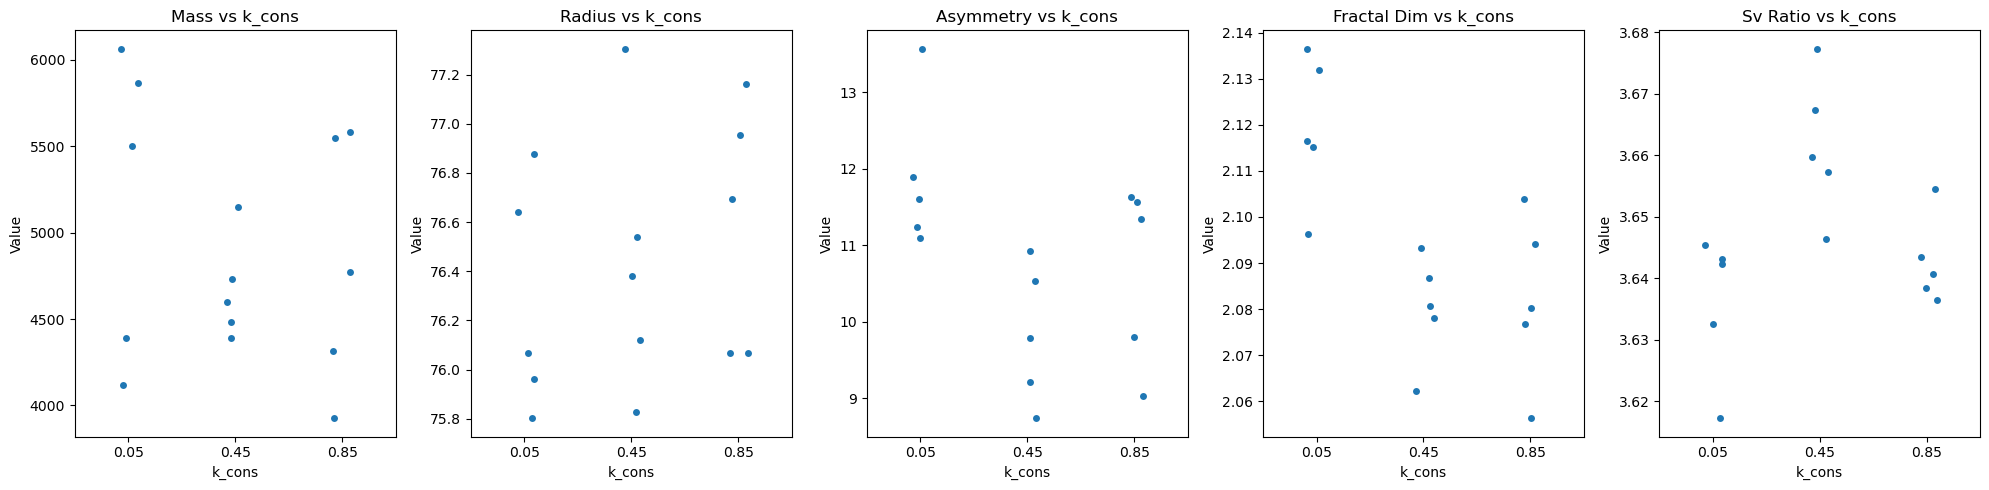

In [9]:
import pandas as pd
import seaborn as sns

# visualization
data_list = []
for metric in metrics_data:
    for k in k_values:
        for value in metrics_data[metric][k]:
            data_list.append({"k_cons": k, "Metric": metric, "Value": value})

df = pd.DataFrame(data_list)
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharex=True)
metrics = ['mass', 'radius', 'asymmetry', 'fractal_dim', 'sv_ratio']

for i, metric in enumerate(metrics):
    sns.stripplot(x="k_cons", y="Value", data=df[df["Metric"] == metric], ax=axes[i], jitter=True)
    axes[i].set_title(f"{metric.replace('_', ' ').title()} vs k_cons")

plt.tight_layout()
plt.show()